In [2]:
%%capture
!pip install vit-keras

In [1]:
%cd drive/MyDrive/MesDossiers/Master CNN/supervised_project/FMRI_ADHD_Classification

/content/drive/MyDrive/MesDossiers/Master CNN/supervised_project/FMRI_ADHD_Classification


In [2]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load fMRI data (.nii.gz)
def load_fmri_data(file_paths):
    data = []
    for path in file_paths:
        img = nib.load(path)
        img_data = img.get_fdata()  # This gives the 4D data: (x, y, z, time)
        data.append(img_data)
    return np.array(data)


# Load the dataset from CSV files
df_total = pd.read_csv("Extracted_Fmri_Data/Total_Data_Pheno.csv")
df_train = pd.read_csv("Extracted_Fmri_Data/Training_Data_Pheno.csv")
df_val = pd.read_csv("Extracted_Fmri_Data/Validation_Data_Pheno.csv")

# Load fMRI data
train_data_paths = df_train['Loc'].tolist()[0:10]
val_data_paths = df_val['Loc'].tolist()[0:2]

In [3]:
# Load data into memory
train_data = load_fmri_data(train_data_paths)
val_data = load_fmri_data(val_data_paths)

In [10]:
print(val_data.shape)

(10, 61, 73, 61, 176)


In [11]:
def preprocess_fmri_data(fmri_data):
    # Flatten the spatial dimensions (x, y, z) and keep the time dimension separate
    flattened_size = fmri_data.shape[1] * fmri_data.shape[2] * fmri_data.shape[3]  # x * y * z

    # Reshape the data to (n_samples, flattened_size, time)
    fmri_data_flattened = fmri_data.reshape(fmri_data.shape[0], flattened_size, fmri_data.shape[-1])

    return fmri_data_flattened


# Preprocess data for the model
train_data_preprocessed = preprocess_fmri_data(train_data)
val_data_preprocessed = preprocess_fmri_data(val_data)

# Define the labels (assuming binary classification for Autism diagnosis, DX 1 = ASD, 2 = Control)
train_labels = np.where(df_train['DX'].values == 1, 1, 0)[0:10]
val_labels = np.where(df_val['DX'].values == 1, 1, 0)[0:2]

In [12]:
print("Train data shape:", train_data_preprocessed.shape)  # Expected: (n_samples, x*y*z, time)
print("Validation data shape:", val_data_preprocessed.shape)  # Expected: (n_samples, x*y*z, time)


Train data shape: (10, 271633, 176)
Validation data shape: (2, 271633, 176)


In [13]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels (ASD = 1, Control = 0)
train_labels_one_hot = to_categorical(train_labels, num_classes=2)
val_labels_one_hot = to_categorical(val_labels, num_classes=2)

# Check shape of the one-hot encoded labels
print(train_labels_one_hot.shape)  # Should be (n_samples, 2)
print(val_labels_one_hot.shape)    # Should be (n_samples, 2)


(10, 2)
(2, 2)


In [14]:
def create_vit_model(input_shape, num_classes, patch_size=61):
    inputs = tf.keras.Input(shape=input_shape)

    # Ensure num_patches fits into input size
    if input_shape[0] % patch_size != 0:
        raise ValueError(f"Patch size {patch_size} does not evenly divide {input_shape[0]}")

    # Reshape the input into patches and project them
    num_patches = input_shape[0] // patch_size
    x = tf.keras.layers.Reshape((num_patches, patch_size * input_shape[1]))(inputs)  # Flatten patches
    x = tf.keras.layers.Dense(64, activation='relu')(x)  # Patch projection

    # Vision Transformer blocks (simplified)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
# Define the number of classes (binary classification: ASD or Control)
num_classes = 2

# Define input shape
input_shape = (train_data_preprocessed.shape[1], train_data_preprocessed.shape[2])  # (flattened_size, time)

# Create the Vision Transformer model
vit_model = create_vit_model(input_shape, num_classes)

# Train the model
history = vit_model.fit(train_data_preprocessed, train_labels_one_hot,
                        epochs=10,
                        validation_data=(val_data_preprocessed, val_labels_one_hot))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9000 - loss: 2.8390 - val_accuracy: 0.5000 - val_loss: 5.4571
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 1.3911e-05 - val_accuracy: 0.5000 - val_loss: 0.8528
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step - accuracy: 0.8000 - loss: 0.2772 - val_accuracy: 0.5000 - val_loss: 3.4256
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 1.0000 - loss: 4.7760e-05 - val_accuracy: 0.5000 - val_loss: 5.7094
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step - accuracy: 1.0000 - loss: 4.6492e-07 - val_accuracy: 0.5000 - val_loss: 7.7069
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step - accuracy: 1.0000 - loss: 1.1921e-08 - val_accuracy: 0.5000 - val_loss: 9.4863
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 11.0869
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accurac

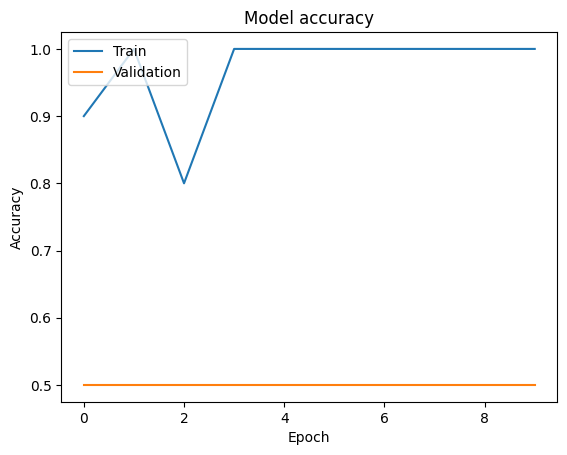

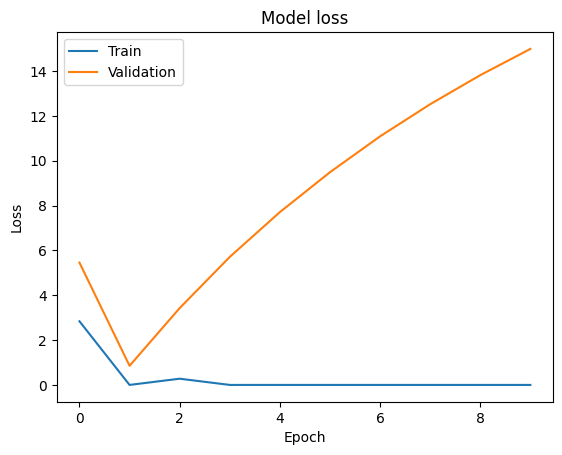

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
import tensorflow as tf

def create_vit_model(input_shape, num_classes, patch_size=61, embedding_dim=64):
    inputs = tf.keras.Input(shape=input_shape)

    # Ensure num_patches fits into input size
    if input_shape[0] % patch_size != 0:
        raise ValueError(f"Patch size {patch_size} does not evenly divide {input_shape[0]}")

    # Reshape the input into patches and project them
    num_patches = input_shape[0] // patch_size
    x = tf.keras.layers.Reshape((num_patches, patch_size * input_shape[1]))(inputs)  # Flatten patches

    # Patch embedding
    x = tf.keras.layers.Dense(embedding_dim, activation='relu')(x)  # Project patches into embedding space

    # Transformer-like block (simplified)
    for _ in range(2):  # Add two transformer-like layers for simplicity
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(x, x)
        x = tf.keras.layers.Add()([x, attention_output])  # Add skip connection
        x = tf.keras.layers.LayerNormalization()(x)  # Normalize

        # Feed-forward part (dense layers)
        x_ffn = tf.keras.layers.Dense(128, activation='relu')(x)
        x_ffn = tf.keras.layers.Dense(embedding_dim)(x_ffn)
        x = tf.keras.layers.Add()([x, x_ffn])  # Add skip connection
        x = tf.keras.layers.LayerNormalization()(x)  # Normalize

    # Global average pooling to aggregate information across all patches
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output layer for classification
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage
input_shape = (3721, 176)  # Example input shape (e.g., flattened fMRI data)
num_classes = 2  # Binary classification for ASD

vit_model = create_vit_model(input_shape, num_classes)
vit_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 3721, 176)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 61, 10736)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 61, 64)         │        687,168 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 61, 64)         │         66,368 │ dense_3[0][0],         │
│ (MultiHeadAttention)      │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 61, 64)         │              0 │ dense_3[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 61, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 61, 128)        │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 61, 64)         │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 61, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 61, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 61, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 61, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 61, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 61, 128)        │          8,320 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 61, 64)         │          8,256 │ dense_6[0][0]          │
├──────────────────────

 Total params: 853,698 (3.26 MB)

 Trainable params: 853,698 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Define the number of classes (binary classification: ASD or Control)
num_classes = 2

# Define input shape
input_shape = (train_data_preprocessed.shape[1], train_data_preprocessed.shape[2])  # (flattened_size, time)

# Create the Vision Transformer model
vit_model = create_vit_model(input_shape, num_classes)

# Train the model
history = vit_model.fit(train_data_preprocessed, train_labels_one_hot,
                        epochs=10,
                        validation_data=(val_data_preprocessed, val_labels_one_hot))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - accuracy: 0.1000 - loss: 1.8140 - val_accuracy: 0.5000 - val_loss: 3.7473
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.6293 - val_accuracy: 0.5000 - val_loss: 4.1486
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.4771 - val_accuracy: 0.5000 - val_loss: 4.0271
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.3604 - val_accuracy: 0.5000 - val_loss: 3.7300
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.2478 - val_accuracy: 0.5000 - val_loss: 3.3452
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.1419 - val_accuracy: 0.5000 - val_loss: 2.9258
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0630 - val_accuracy: 0.5000 - val_loss: 2.5124
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0256 - val_accuracy: 0.5000 - val_loss: 2.1520
Epoch 9/10
1/1

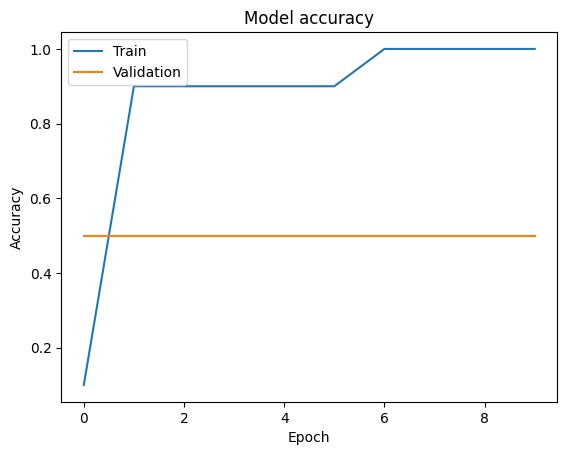

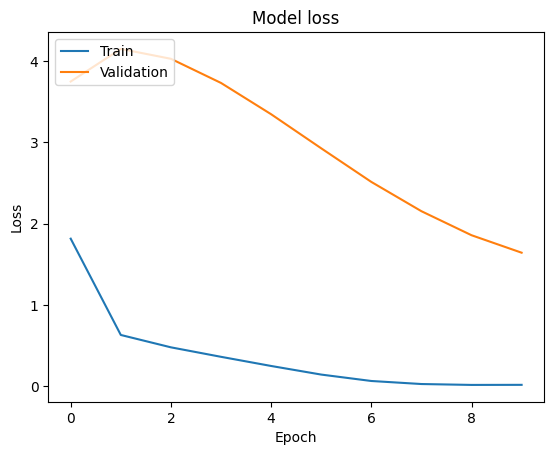

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()